In [1]:
# Included needed libraries.
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import seaborn as sns
from datetime import datetime
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras import regularizers

# Preconfigured CUDA+CUDNN GPU utilisation before the notebook to speed up the training
print("CUDA Built with TensorFlow:", tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

CUDA Built with TensorFlow: True
Num GPUs Available:  1


In [2]:
# Initialise the FER-2013 dataset.
data_dir = 'FER-2013-DATASET/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')
train_folders = [folder for folder in os.listdir(train_dir)]
test_folders = [folder for folder in os.listdir(test_dir)]

# Count images in train folder
train_count = []
print("Train Set :")
for folder in train_folders:
    num_images = len(os.listdir(os.path.join(train_dir, folder)))
    print(folder, "folder contains", num_images, "images")
    train_count.append(num_images)

# Count images in test folder
test_count = []
print("\nTest Set :")
for folder in test_folders:
    num_images = len(os.listdir(os.path.join(test_dir, folder)))
    print(folder, "folder contains", num_images, "images")
    test_count.append(num_images)

Train Set :
angry folder contains 3995 images
disgust folder contains 436 images
fear folder contains 4097 images
happy folder contains 7214 images
neutral folder contains 4965 images
sad folder contains 4830 images
surprise folder contains 3171 images

Test Set :
angry folder contains 958 images
disgust folder contains 111 images
fear folder contains 1024 images
happy folder contains 1774 images
neutral folder contains 1233 images
sad folder contains 1247 images
surprise folder contains 831 images


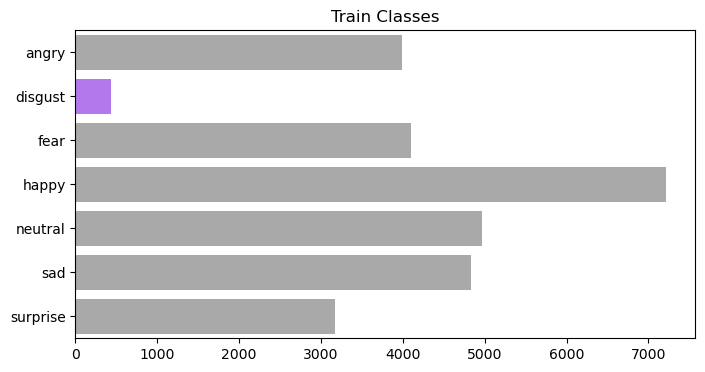

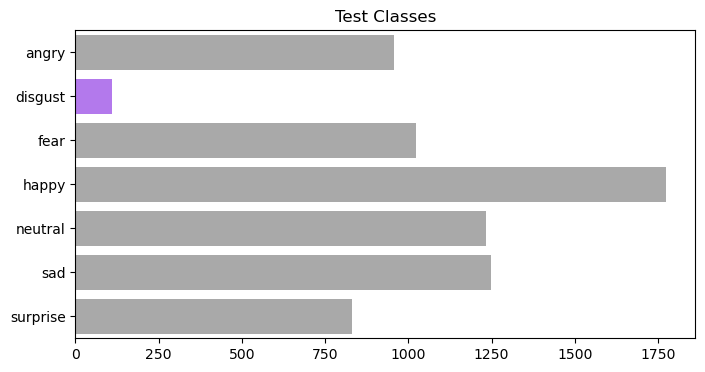

In [3]:
# Check if we should modify/trim the dataset.
vals = ["disgust"] # Disgust was detected to have a very low count compared to the other classes in the dataset. Checking it further visually:
main_accent_colour = "#b366ff"
dim_colour = "darkgrey"
main_palette = ["#FBE5C0", "#DD9A30", "#F88379", "#FF6FC2", "purple", "#D086F6", "#B0D2C2", "#4C5D70", "#6FA2CE", "#382D24", "#3ACF3A", "#7D7D00"]
palette = {c: dim_colour if c not in vals else main_accent_colour for c in train_folders}

# Plot train classes
plt.figure(figsize=(8, 4))
ax = sns.barplot(y=train_folders, x=train_count, palette=palette, hue=train_folders, orientation="horizontal", legend=False)
ax.set_title('Train Classes')
plt.show()

# Plot test classes
plt.figure(figsize=(8, 4))
ax = sns.barplot(y=test_folders, x=test_count, palette=palette, hue=test_folders, orientation="horizontal", legend=False)
ax.set_title('Test Classes')
plt.show()

In [4]:
# Remove the low count class from the dataset and load the other classes in a training_set and test_set for ML model training purpose.

# Define new folders excluding the disgust class
train_folders = [folder for folder in os.listdir(train_dir) if folder != 'disgust']
test_folders = [folder for folder in os.listdir(test_dir) if folder != 'disgust']

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    rescale=1./255,
)
validation_datagen = ImageDataGenerator(rescale = 1./255)



training_set = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (48,48),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    classes = [folder for folder in train_folders]
                                                   )
test_set = validation_datagen.flow_from_directory(directory = test_dir,
                                                              target_size = (48,48),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              classes = [folder for folder in test_folders]
                                                             )
training_set.class_indices

test_set.class_indices

Found 28272 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


{'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}

In [5]:
# Initialise and compile the model.
model = Sequential()

# First Convolutional Block
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Second Convolutional Block
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Third Convolutional Block
model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Model compilled successfully!")

Model compilled successfully!


In [6]:
# Configure early stop, history saving in CVS and logging durring training.
chk_path = 'sequential_model.h5'
log_dir = "checkpoint/logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='max',
                             monitor='val_accuracy')

early_stop = EarlyStopping(monitor='val_accuracy', 
                          patience=20, # Wait for 20 epochs of no improvement before stopping
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.4, # new learning_rate = 0.4 * old learning_rate
                              patience=7, # Wait for 7 epochs without improvement before reducing the learning rate
                              verbose=1, 
                              min_delta=0.001) # Require a 0.01% improvement to reset patience


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, early_stop, tensorboard_callback, csv_logger]

# Define steps per epoch for training and validation
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

print("Model callbacks (additional configurations) introduced.")

Model callbacks (additional configurations) introduced.


In [7]:
# Train the model. Track training time.
start_time = datetime.now()
print(f"Training started at: {start_time.strftime('%H:%M:%S')}")
history = model.fit(x=training_set,
                  validation_data=test_set,
                  epochs=250,
                  callbacks=callbacks,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)
end_time = datetime.now()
print(f"Training finished at: {end_time.strftime('%H:%M:%S')}")

Training started at: 08:31:57
Epoch 1/250
441/441 [==============================] - ETA: 0s - loss: 2.7680 - accuracy: 0.2100
Epoch 1: val_accuracy improved from -inf to 0.24062, saving model to sequential_model.h5
441/441 [==============================] - 217s 481ms/step - loss: 2.7680 - accuracy: 0.2100 - val_loss: 2.6723 - val_accuracy: 0.2406 - lr: 1.0000e-04
Epoch 2/250
441/441 [==============================] - ETA: 0s - loss: 2.4791 - accuracy: 0.2342
Epoch 2: val_accuracy improved from 0.24062 to 0.31023, saving model to sequential_model.h5
441/441 [==============================] - 40s 90ms/step - loss: 2.4791 - accuracy: 0.2342 - val_loss: 2.1049 - val_accuracy: 0.3102 - lr: 1.0000e-04
Epoch 3/250
441/441 [==============================] - ETA: 0s - loss: 2.3723 - accuracy: 0.2573
Epoch 3: val_accuracy improved from 0.31023 to 0.32472, saving model to sequential_model.h5
441/441 [==============================] - 42s 95ms/step - loss: 2.3723 - accuracy: 0.2573 - val_loss: 2

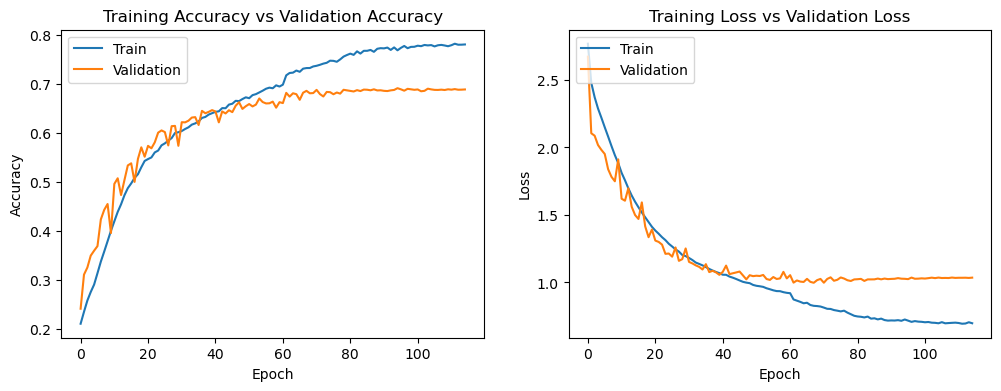

In [8]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [9]:
# Load the trained model
loaded_model = tf.keras.models.load_model('sequential_model.h5')

In [ ]:
# Load the Haar Cascade for face detection
face_cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(face_cascade_path)

# Initialize the video capture
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame.")
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)

    for (x, y, w, h) in faces:
        # Draw rectangle around the face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Get the region of interest (ROI) for emotion detection
        roi_gray = gray[y:y + h, x:x + w]
        roi_color = frame[y:y + h, x:x + w]

        # Resize and reshape for the model input
        final_image = cv2.resize(roi_gray, (48, 48))  # Resize to 48x48
        final_image = final_image.astype('float32') / 255.0  # Normalize to [0, 1]
        final_image = np.expand_dims(final_image, axis=-1)  # Add channel dimension
        final_image = np.expand_dims(final_image, axis=0)  # Add batch dimension

        # Predict emotion
        Predictions = loaded_model.predict(final_image)

        # Get the emotion with the highest predicted probability
        emotion_index = np.argmax(Predictions)
        class_labels = {v: k for k, v in training_set.class_indices.items()}
        emotions = [class_labels[i] for i in sorted(class_labels)]
        status = emotions[emotion_index]

        # Create a box to display the emotion
        x1, y1, w1, h1 = 0, 0, 175, 75
        cv2.rectangle(frame, (x1, y1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        cv2.putText(frame, status, (x1 + 10, y1 + int(h1 / 2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # Display the result
    cv2.imshow("Face Emotion Recognition", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()